In [79]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
import os.path
hvlist = np.loadtxt('hvlist.txt')
f = open(f'namelist.txt', "r", encoding="utf-8")
str1 = f.read()
namelist = str1.split()
mcmcdir = 'mcmc2'

## define Fflux & load x,y

In [80]:
#import NEATM
from NEATM2 import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]
#....define f
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
def Model_neatm_Ref_jhx(theta,x,lamda,nn4):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf = theta
    astp,obsp = x
    lamda1,lamda2,lamda3,lamda4 = lamda
    #print('k',astp)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    flux = np.zeros(nn4*4)
    for i in range(nn4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda1,eta,A,Hv)
        flux[i] = 1.3917*fluxi + 1.0049*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(nn4,2*nn4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = 1.1124*fluxi + 1.0193*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(2*nn4,nn4*3):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A,Hv)
        flux[i] = 0.8791*fluxi 
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(nn4*3,nn4*4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A,Hv)
        flux[i] = 0.9865*fluxi     
       # print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    return flux  

In [81]:
print(namelist)

['1994CB', '1996GQ', '2002LT24', '2003MA3', '2008NP3', '2009UX17', '2010AJ30', '2010BH115', '2010CA55', '2010CC55', '2010CN141', '2010CO1', '2010DG77', '2010DH77', '2010EX11', '2010FA81', '2010FC81', '2010FH81', '2010GP67', '2010GS7', '2010HW81', '2010HX107', '2010HZ104', '2010JN71', '2010JX16', '2010KP10', '2010KU7', '2010KX7', '2010LH14', '2010LJ68', '2010LK68', '2010LL68', '2010LV108', '2010NS36', '2010NY65', '2010OH126', '2010PU66', '2010PW58', '2010XP69', '2014FD7', '2015TF', '2016UH101', '2019DD2']


In [82]:
nni = 33
name = namelist[nni]
Hv = hvlist[nni]

name

'2010NS36'

In [83]:
#.........load xy
#df = pd.read_table(f'ws.dat.{name}')
ast = np.loadtxt(f'./{mcmcdir}/datepoch/ws.dat.{name}',skiprows=1,usecols=(5,6,7))
ear = np.loadtxt(f'./{mcmcdir}/datepoch/ws.dat.{name}',skiprows=1,usecols=(8,9,10))
#ast-sun
d_N = np.sqrt(ast[:,0]**2+ast[:,1]**2+ast[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((ast[:,0]-ear[:,0])**2+(ast[:,1]-ear[:,1])**2+(ast[:,2]-ear[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(ear[:,0]**2+ear[:,1]**2+ear[:,2]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
x = (delta_N,d_N,alpha_N)

time = np.loadtxt(f'./{mcmcdir}/datjd/mba.jd.{name}')
mjdtime = time-2400000.5
obsdat = np.loadtxt(f'./{mcmcdir}/datwise/obsNEW.txt.{name}')
n4 = len(obsdat)//4
w1 = obsdat[:n4]
w2 = obsdat[n4:2*n4]
w3 = obsdat[2*n4:n4*3]
w4 = obsdat[n4*3:]
y = obsdat  
#..........
xast = np.vstack((ast,ast,ast,ast))
xear  =  np.vstack((ear,ear,ear,ear))
xt = (xast,xear)

## read samples

In [84]:
samples0 = np.loadtxt(f'./{mcmcdir}/figmcmc/samples/samples_{0}.txt.{name}')
samples1 = np.loadtxt(f'./{mcmcdir}/figmcmc/samples/samples_{1}.txt.{name}')
samples2 = np.loadtxt(f'./{mcmcdir}/figmcmc/samples/samples_{2}.txt.{name}')
samples = [samples0,samples1,samples2]

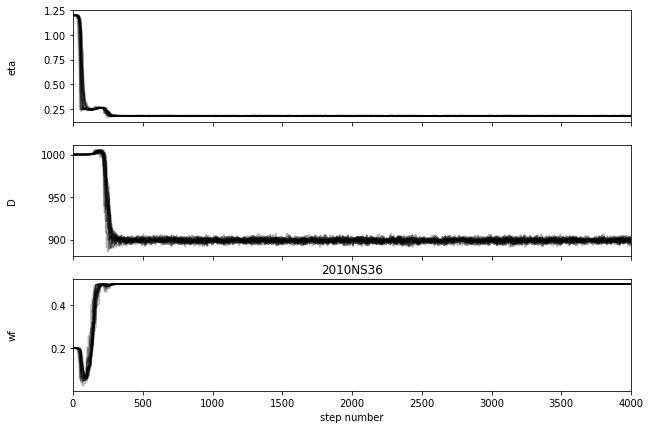

In [85]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["eta", "D", "wf"]
ndim = len(labels)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples[i]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.title(name)
plt.savefig(f'./{mcmcdir}/figflux/chain_{name}.png',transparent=True)

## read fitans

In [86]:
datans = np.loadtxt(f'./{mcmcdir}/ansfit/fit.txt.{name}')
eta_fit,D_fit,wf_fit = datans[4]
pv = datans[3][1]
from IPython.display import display, Math
for i in range(ndim):
    ans = datans[i]
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(ans[0], ans[1], ans[2], labels[i])
    display(Math(txt))
print(f'eta = {eta_fit} D ={D_fit} pv = {pv} wf ={wf_fit}')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

eta = 0.17879868656279674 D =898.9556816488838 pv = 1.5120752284854657 wf =0.4999404617465055


(4520, 3)


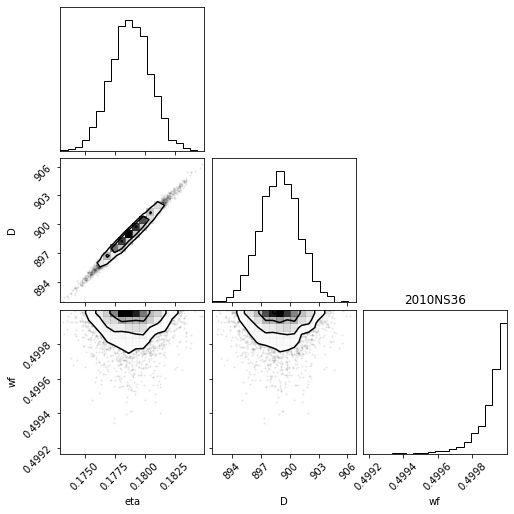

In [87]:

#--------------------------
flat_samples = np.loadtxt(f'./{mcmcdir}/figmcmc/samples/flatsam.txt.{name}')
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[1.2, 125,0.2]
);
plt.title(name)
plt.savefig(f'./{mcmcdir}/figflux/cornor_{name}.png',transparent=True)


/home/astrohhq/learngit/newwisedata/testssh_ans/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/newwisedata/testssh_ans/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


LossFunction =  876.5313464592589


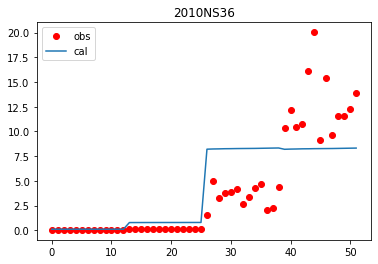

In [88]:
plt.plot(y,'ro',label='obs')
#plt.errorbar(y,y*0.1,fmt=".k", capsize=1.0)
test = [eta_fit, D_fit, wf_fit]
plt.plot(Model_neatm_Ref_jhx(test,xt,lamdai,n4),label='cal')
plt.legend()
plt.title(name)
print('LossFunction = ',loss(y,Model_neatm_Ref_jhx(test,xt,lamdai,n4),y*0.1))
plt.savefig(f'./{mcmcdir}/figflux/4b_{name}.png',transparent=True)

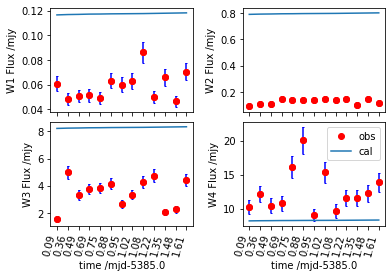

In [89]:
tjd = np.loadtxt(f'./{mcmcdir}/datjd/mba.jd.{name}')
tmjd = tjd-2450000.5
roundmjd = np.around(tmjd,0)
rmjd = min(roundmjd)
#print(rmjd)
xtime = np.around(tmjd-rmjd,2)
yflux = Model_neatm_Ref_jhx(test,xt,lamdai,n4)
plt.subplot(2,2,1)
plt.plot(y[:n4],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[:n4], yerr=y[:n4]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[:n4],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
#plt.xlabel('time /mjd')
plt.ylabel('W1 Flux /mjy')
ax1 = plt.gca()
ax1.axes.xaxis.set_ticklabels([])

plt.subplot(2,2,2)
plt.plot(y[n4:n4*2],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4:n4*2], yerr=y[n4:n4*2]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4:n4*2],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
#plt.xlabel('time /mjd')
plt.ylabel('W2 Flux /mjy')
ax2 = plt.gca()
ax2.axes.xaxis.set_ticklabels([])

plt.subplot(2,2,3)
plt.plot(y[n4*2:n4*3],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4*2:n4*3], yerr=y[n4*2:n4*3]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4*2:n4*3],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
plt.xlabel(f'time /mjd-{rmjd}')
plt.ylabel('W3 Flux /mjy')

plt.subplot(2,2,4)
plt.plot(y[n4*3:],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4*3:], yerr=y[n4*3:]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4*3:],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
plt.xlabel(f'time /mjd-{rmjd}')
plt.ylabel('W4 Flux /mjy')
plt.legend()
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.1)
#print(len(tjd),n4)
plt.savefig(f'./{mcmcdir}/figflux/1b_{name}.png',transparent=True)

In [90]:
for i in range(namelist):
    name = namelist[i]
    ph = f'./{mcmcdir}/ansfit/fit.txt.{name[i]}'
    if not os.path.isfile(f'./{mcmcdir}/ansfit/fit.txlistt.{name}'):
        continue
    Hv = hvlist[i]

TypeError: 'list' object cannot be interpreted as an integer